In [1]:
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray, ycbcr2rgb
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR

import skimage.transform as tf

def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

In [2]:
original_peppers = imread('../lab_images/peppers.png')
peppers = rgb2ycbcr(imread('../lab_images/peppers.png'))
lena = rgb2gray(imread('../lab_images/lena.tiff'))
peppers.shape

(384, 512, 3)

In [3]:
luma = peppers[..., 0]
cb = peppers[..., 1]
cr = peppers[..., 2]

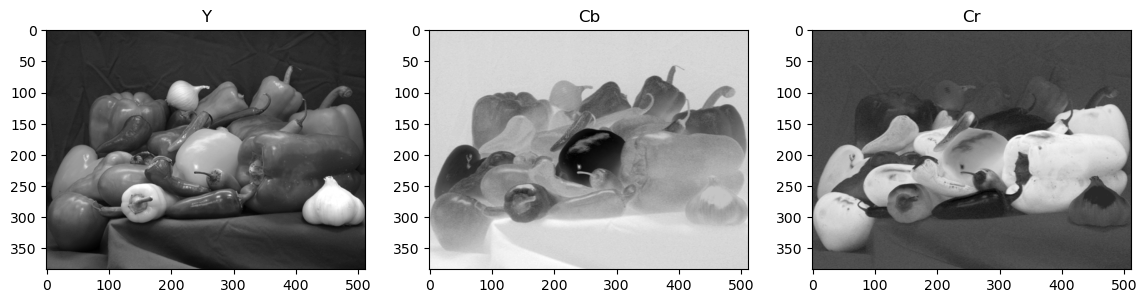

In [4]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 3, 1)

plt.title("Y")
plt.imshow(luma, cmap = 'gray')

plt.subplot(1, 3, 2)

plt.title("Cb")
plt.imshow(cb, cmap = 'gray')

plt.subplot(1, 3, 3)

plt.title("Cr")
plt.imshow(cr, cmap = 'gray')

plt.show()

1. Describe the Cb and Cr channel images. Why do they appear this way?

The Cb and Cr channel images are the blue and red-difference chroma components, respectively. They emphasize the color variations in the image rather than the brightness. The Cb image highlights the difference between the blue component and the luma (Y), showing stronger contrast for the areas with blue tones. Whereas, the Cr image highlights the difference between the red component and the luma, capturing red-toned regions. They don't carry detailed spatial information but they focus on the color content.

2. Compare the level of image detail in the Cb and Cr images with the Y channel image. Which contains more fine details? What does that say about the luma (Y) and chroma (Cb and Cr) channels?

The Y channel contains significantly more fine details compared to the Cb and Cr channels. It captures the luminance (brightness) information, which is needed for seeing spatial structure and texture in the image.

The Cb and Cr channels prioritize color information and therefore appear smoother, with less spatial detail. In the Cr image, we can see some shadows showing more detail, but it's still minimal compared to the Y channel. This indicates that the luma channel plays an important role in preserving the image's fine details, while the chroma channels are primarily used to represent color information.

In [5]:
def reduce_resolution(image, title, factor):
    """
    reduce each image resolution by a factor of 2 (horizontally and vertically)
    """
    new_shape = image.shape[0] // factor, image.shape[1] // factor
    print(f"Old shape: {image.shape}, New shape: {new_shape}")
    image = tf.resize(image, new_shape, order=1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    print(image.shape)
    return image

Old shape: (384, 512), New shape: (192, 256)


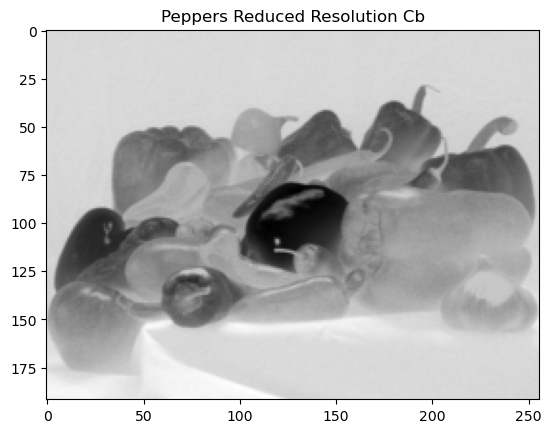

(192, 256)


In [6]:
peppers_reduced_cb = reduce_resolution(cb, "Peppers Reduced Resolution Cb", 2)

Old shape: (384, 512), New shape: (192, 256)


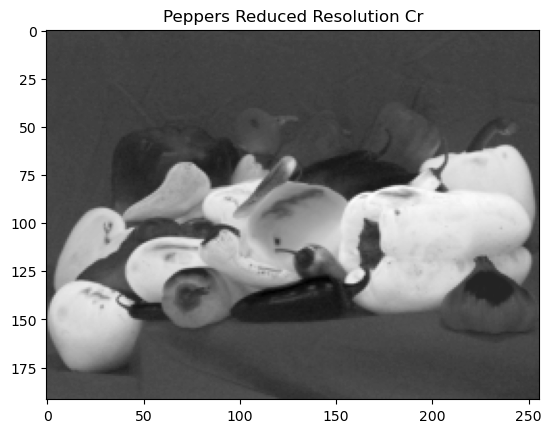

(192, 256)


In [7]:
peppers_reduced_cr = reduce_resolution(cr, "Peppers Reduced Resolution Cr", 2)

In [8]:
def digital_zoom(image, factor, order, title):
    """
    Perform digital zoom where order NN = 0, bilinear = 1, bicubic = 3
    """
    new_shape = image.shape[0] * factor, image.shape[1] * factor
    # print(f"Old shape: {image.shape}, New shape: {new_shape}")
    image = tf.resize(image, new_shape, order=order)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    return image

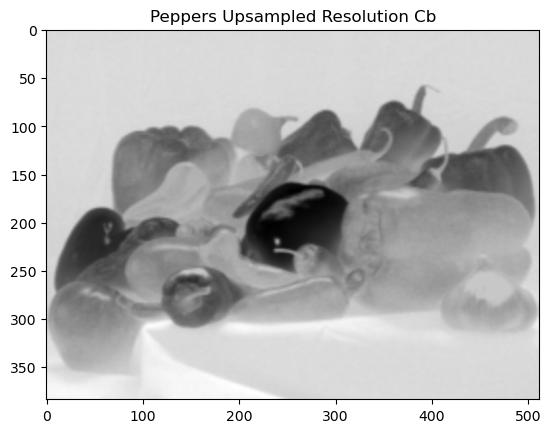

In [9]:
peppers_upsampled_cb = digital_zoom(peppers_reduced_cb, 2, 1, "Peppers Upsampled Resolution Cb")

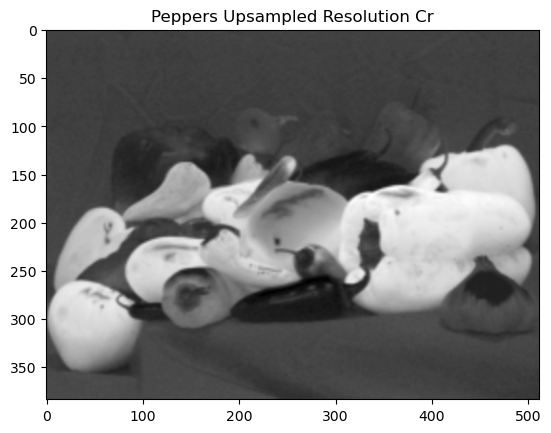

In [10]:
peppers_upsampled_cr = digital_zoom(peppers_reduced_cr, 2, 1, "Peppers Upsampled Resolution Cr")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17461434003481036..1.116647777085364].


Text(0.5, 1.0, 'Recombined Peppers Upsampled Cb and Cr')

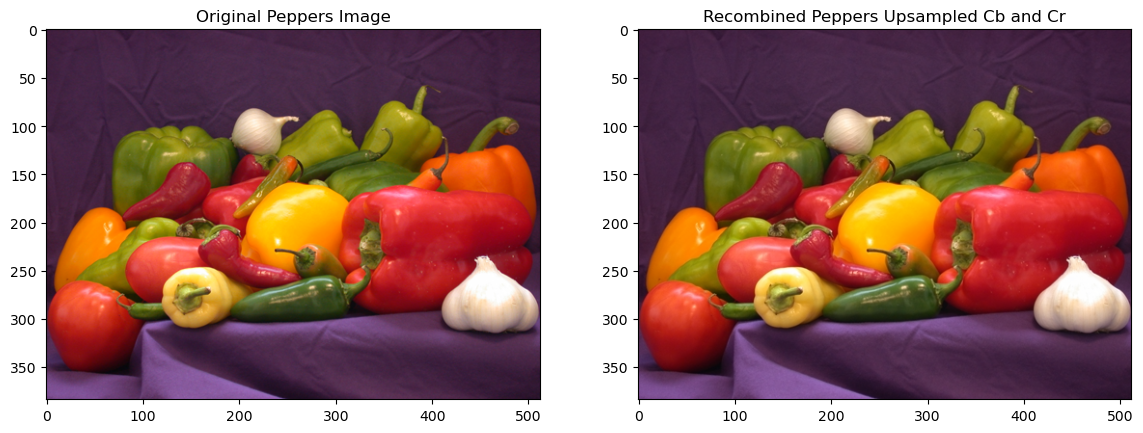

In [11]:
# recombine the Y with upsampled Cb and Cr to create new image
recombined_chroma_peppers = np.stack([luma, peppers_upsampled_cb, peppers_upsampled_cr])
recombined_chroma_peppers = np.transpose(recombined_chroma_peppers, axes=(1, 2, 0))
recombined_chroma_peppers_rgb = ycbcr2rgb(recombined_chroma_peppers)
recombined_chroma_peppers.shape

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(original_peppers)
plt.title('Original Peppers Image')

plt.subplot(1, 2, 2)
plt.imshow(recombined_chroma_peppers_rgb)
plt.title('Recombined Peppers Upsampled Cb and Cr')

3. Compare the resulting image from chroma sub-sampling with the original image. How large are the visual differences?

The chroma sub-sampling image looks the exact same as the original image. This makes sense as the human visual system is much more sensitive to luminance than to chroma channels (Cr and Cb). By downscaling and then upscaling the chroma channels, the loss of fine details in the color information is not noticeable to the human eye. The luminance channel, which didn't lose any information, makes sure that the image still looks sharp and detailed.

4. Based on the resulting image, what can you say about chroma sub-sampling and its effect on image quality?

Chroma sub-sampling is an effective technique for reducing the bandwidth required for image/video transmission while preserving the perceived image quality. Since chroma subsampling reduces the resolution of the Cb and Cr channels, it significantly reduces the amount of data needed to represent the image. However as we said, the impact on visual quality is minimal because the human eye is less sensitive to the chroma changes. 

Old shape: (384, 512), New shape: (192, 256)


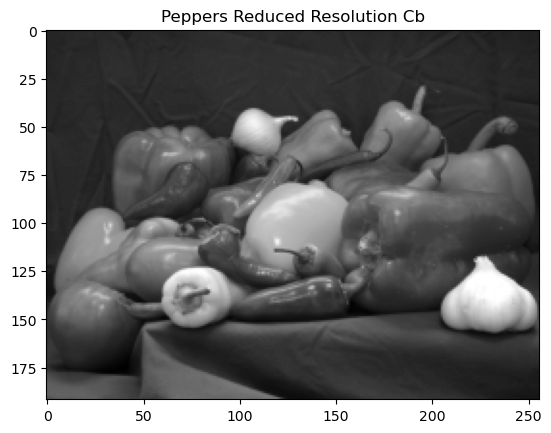

(192, 256)


In [12]:
peppers_reduced_luma = reduce_resolution(luma, "Peppers Reduced Resolution Cb", 2)

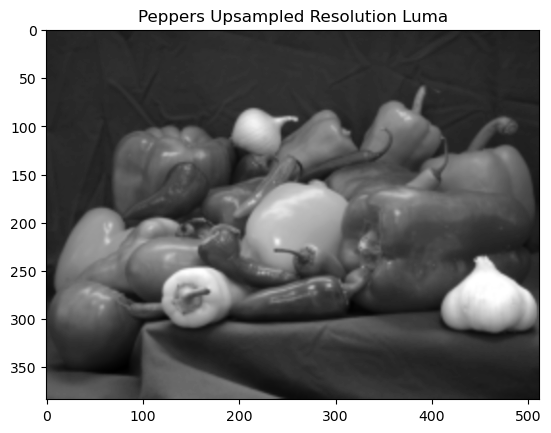

In [13]:
peppers_upsampled_luma = digital_zoom(peppers_reduced_luma, 2, 1, "Peppers Upsampled Resolution Luma")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13072178154792485..1.072384690967729].


Text(0.5, 1.0, 'Recombined Peppers Upsampled Luma')

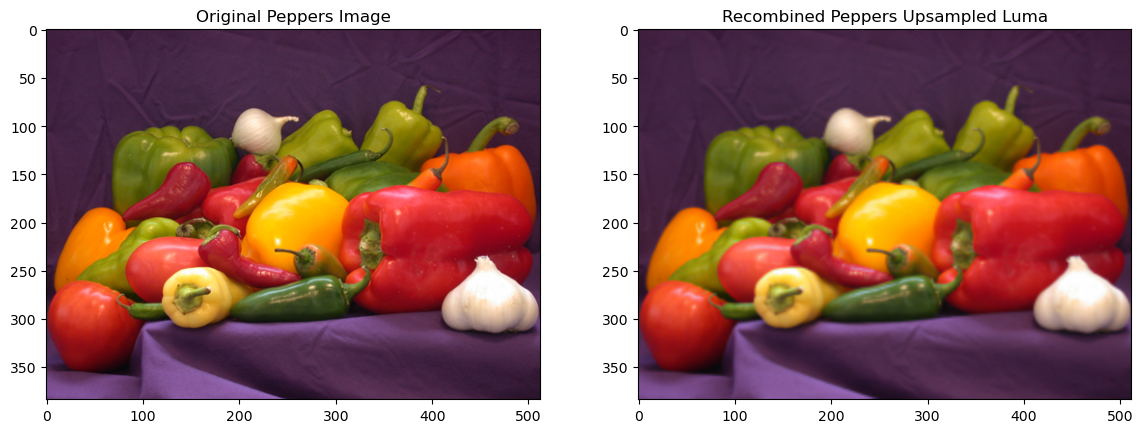

In [14]:
recombined_luma_peppers = np.stack([peppers_upsampled_luma, cb, cr])
recombined_luma_peppers = np.transpose(recombined_luma_peppers, axes=(1, 2, 0))
recombined_luma_peppers_rgb = ycbcr2rgb(recombined_luma_peppers)
recombined_luma_peppers.shape


plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(original_peppers)
plt.title('Original Peppers Image')

plt.subplot(1, 2, 2)
plt.imshow(recombined_luma_peppers_rgb)
plt.title('Recombined Peppers Upsampled Luma')

5. Compare the resulting image from luma sub-sampling with the original image. How large are the visual differences?

The luma sub-sampled image is blurrier than the original image. Hence, the visual difference is decently large, especially compared to the chroma sub-sampling. The fine details and sharpness of the image are lost because the luma channel mainly contains the spatial information and brightness variations that define the texture and structure of the image. The image is blurry in areas with intricate details, as bilinear interpolation cannot perfectly reconstruct the original resolution after subsampling.

6. Based on the resulting image, what can you say about luma sub-sampling and its effect on image quality?

Luma subsampling has a stronger negative impact on image quality compared to chroma subsampling. Since the luma channel carries the majority of the perceptual detail in the image, reducing its resolution directly affects the viewer's ability to see fine details and sharpness. So, while luma subsampling might reduce data size, it is less desirable for compression compared to chroma subsampling due to the visible quality loss.

7. Compare the resulting image from luma sub-sampling with the image produced using chroma sub-sampling. Which method performs better? Which is better for reducing network bandwidth while preserving visual acuity? Why?

Chroma sub-sampling performs better than luma sub-sampling in terms of preserving visual quality. This is because the human visual system is more sensitive to luma (brightness and details) than chroma (color information). Loss of detail in the chroma channels is less noticeable, whereas any degradation in the luma channel significantly affects the image's sharpness and overall quality. Thus, chroma sub-sampling is better for reducing network bandwidth while maintaining visual acuity. It allows for significant compression with minimal perceptual impact. This happens because the luma channel carries spatial and brightness details that define the image's clarity and sharpness, whereas the chroma channels contribute primarily to color information, which the human eye perceives with lower sensitivity to fine detail. Thus, reducing chroma resolution has a negligible effect on perceived image quality.

Part 3 Colour Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-36.183641809551716..100.0].


Text(0.5, 1.0, 'L*a*b* Peppers')

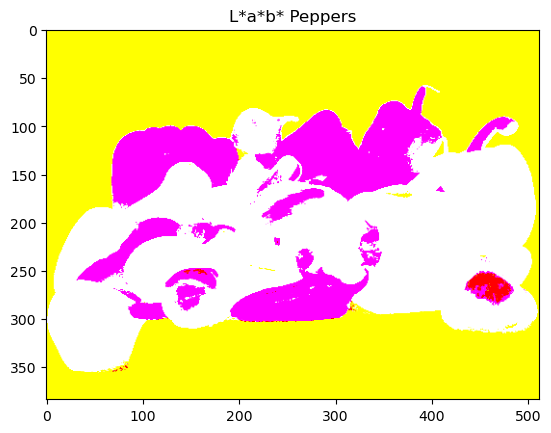

In [15]:
p_lab = rgb2lab(original_peppers)
plt.imshow(p_lab)
plt.title('L*a*b* Peppers')

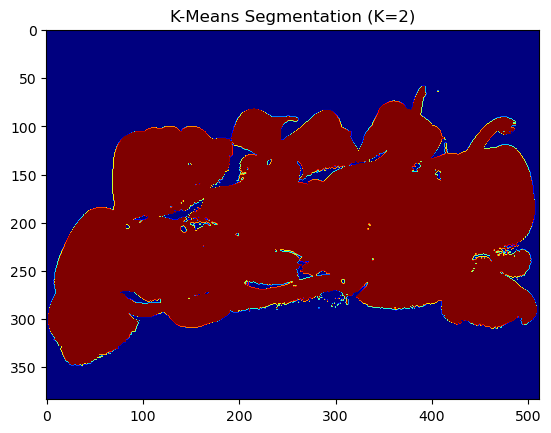

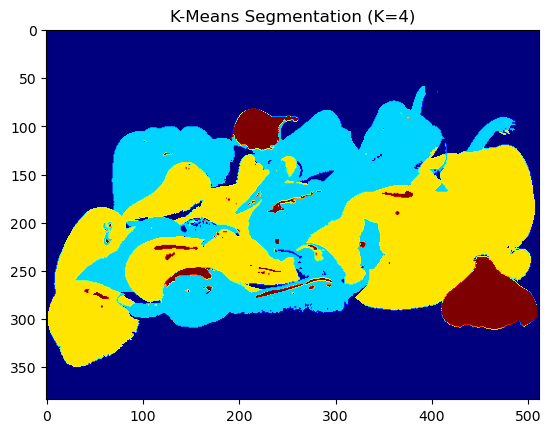

In [16]:
# Function to initialize cluster centers
def mu(lab_image, row, col):
    """Extract initial cluster centers based on row and column indices."""
    mu = lab_image[row,col]
    return mu

# Reshape the L*a*b* channels
m, n, ch = p_lab.shape
reshape_p_lab = np.reshape(p_lab, (m * n, ch), order='F')

# Perform KMeans clustering for K = 2
row_k2 = np.array([55, 200]) - 1
col_k2 = np.array([155, 400]) - 1

mu_k2 = mu(p_lab, row_k2, col_k2)

kmeans_k2 = KMeans(n_clusters=2, init=mu_k2, random_state=42)
cluster_idx_k2 = kmeans_k2.fit_predict(reshape_p_lab)

# Reshape the cluster indices to match the original image dimensions
segmented_k2 = np.reshape(cluster_idx_k2, (m, n), order='F')

plt.imshow(segmented_k2, cmap='jet')
plt.title('K-Means Segmentation (K=2)')
plt.show()

# Perform KMeans clustering for K = 4
row_k4 = np.array([55, 130, 200, 280]) - 1
col_k4 = np.array([155, 110, 400, 470]) - 1

mu_k4 = mu(p_lab, row_k4, col_k4)

kmeans_k4 = KMeans(n_clusters=4, init=mu_k4, random_state=42)
cluster_idx_k4 = kmeans_k4.fit_predict(reshape_p_lab)

segmented_k4 = np.reshape(cluster_idx_k4, (m, n), order='F')

plt.imshow(segmented_k4, cmap='jet')
plt.title('K-Means Segmentation (K=4)')
plt.show()


8. For the various values of k, how did the clustering change? Explain.

For k = 2, the segmentation isn't very elaborate. One segment is the background and the other are the vegetables. The segmentation doesn't capture finer details or variations within the vegetables, as the number of clusters is too small to differentiate between colours or luminance.

For k = 4, there's a better segmentation between peppers with different colours/luminance. Hence, the clustering is more detailed, dividing the image into more specific regions. This allows for better segmentation between vegetables with varying colors (e.g., red, green, and yellow peppers) and provides a clearer representation of the image.

9. What is the effect of the initial points on the final clusters? Does this impose any limitations? Why?

The initial points strongly influence the convergence of the K-means algorithm. K-means minimizes the distance between points and their cluster centers, so poor initialization can lead to suboptimal solutions with clusters that don't represent the image features well. The dependency on initial points imposes a limitation because it introduces randomness and variability in the clustering outcome. This can make the results less consistent if the initialization is not carefully chosen. K-means is sensitive to the starting positions because the algorithm updates the cluster centers iteratively by averaging the points assigned to each cluster. Poor initialization can lead to: slower convergence and clusters that don’t align with natural groupings in the data.

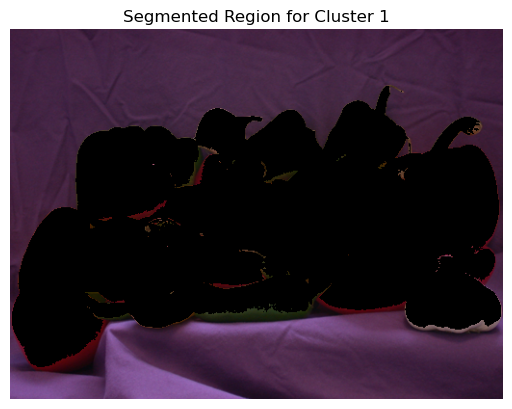

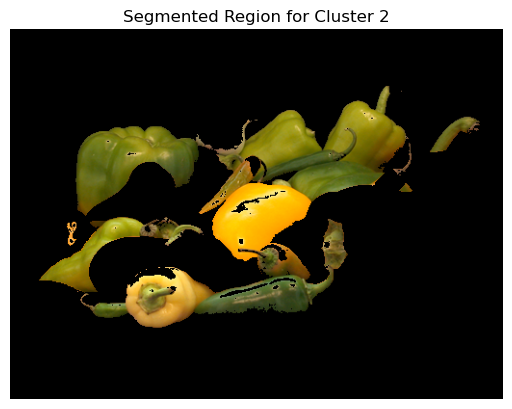

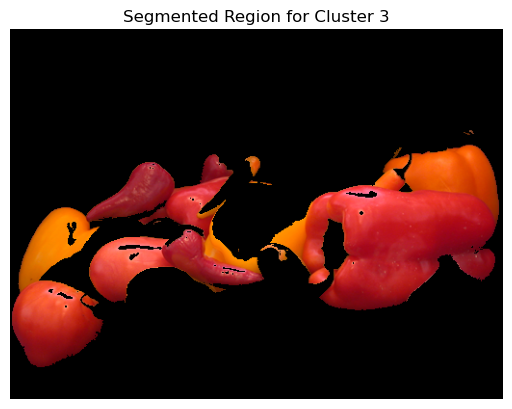

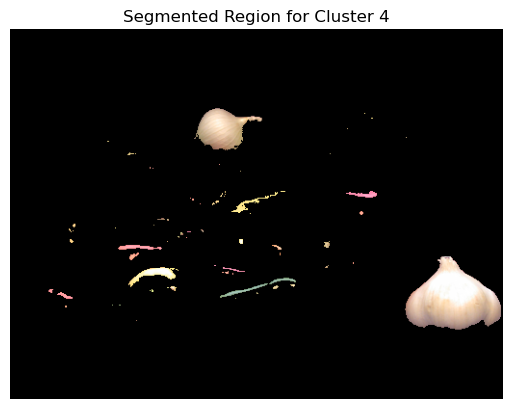

In [17]:
segmented_images_k4 = []

for cluster_label in range(4):  # Loop through each cluster
    # Create a mask for the current cluster
    mask = (segmented_k4 == cluster_label)
    
    # Initialize an empty image with the same shape as the original
    segmented_image = np.zeros_like(original_peppers)
    
    # Apply the mask to the original image
    for c in range(3):  # Loop through each color channel (R, G, B)
        segmented_image[..., c] = original_peppers[..., c] * mask
    
    segmented_images_k4.append(segmented_image)
    
    # Display the segmented region
    plt.imshow(segmented_image)
    plt.title(f'Segmented Region for Cluster {cluster_label + 1}')
    plt.axis('off')
    plt.show()



10. Include an image of each cluster and comment on the segmentation performance.

The segmentation effectively groups regions of the image based on color similarity in the L*a*b* color space. Cluster 1 successfully segments the background, accurately separating it from the objects. Cluster 2 groups green and yellow peppers together, reflecting that these colors are similar enough in the color space to be classified as one cluster. Similarly, Cluster 3 combines orange and red peppers. Cluster 4 captures "miscellaneous" elements, such as garlic, reflections on the peppers, and other colors not easily categorized into the main clusters.

A significant advantage of the segmentation is the precise separation of the background (Cluster 1). The grouping of green/yellow and orange/red peppers into clusters also demonstrates the algorithm's effectiveness in handling similar hues. However, there are some limitations. Grouping green and yellow peppers together (Cluster 2) and orange and red peppers together (Cluster 3) might overlook subtle differences between these colors, which could be important for depending on the application. Also, the "random" nature of Cluster 4 shows that the algorithm struggles with outlier regions, grouping them without clear consistency.

Part 4 Image Transform

Text(0.5, 1.0, '8x8 DCT transform matrix')

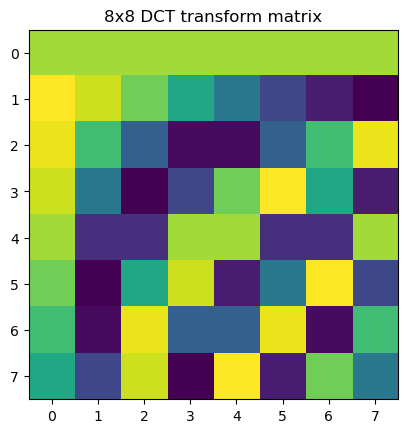

In [18]:
T = dctmtx(8)

plt.imshow(T)
plt.title("8x8 DCT transform matrix")

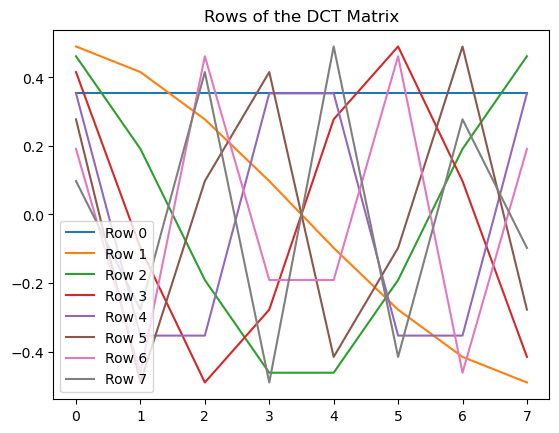

In [19]:
# plot each row as a function
for i, row in enumerate(T):
    plt.plot(np.arange(0, 8), row, label=f"Row {i}")
    plt.title("Rows of the DCT Matrix")
    plt.legend()

11. What does each row of the DCT transform matrix represent? Look at the pattern for each row. If you still don’t see it, try plotting each of the rows as a 1-D function.

Each row represents a sinusoid with different frequencies. The first row is a cosine wave with zero frequency, so it's the lowest frequency (DC component). The following rows add more oscillations (higher frequencies) within the same interval, capturing higher-frequency components of the signal.

Text(0.5, 1.0, 'DCT of block (0, 0)')

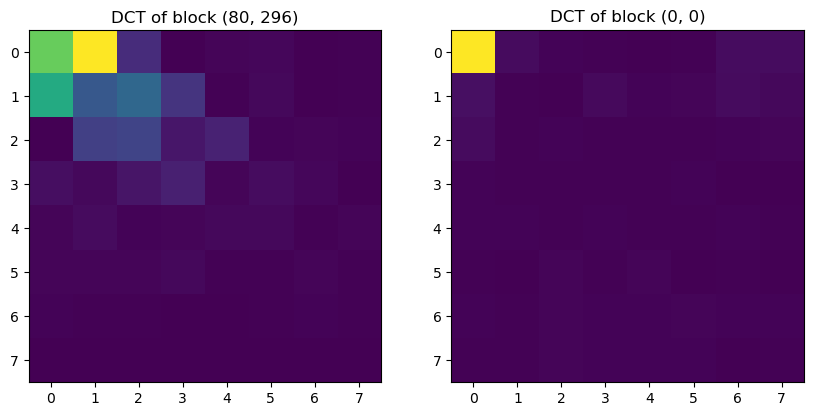

In [20]:
F_trans = np.floor(blockproc((lena*255)-128, T, [8, 8], func))

# 8x8 blocks
block1 = F_trans[80:80+8, 296:296+8] # Starts at (80,296)
block2 = F_trans[0:0+8, 0:0+8] # Starts at (0,0)

# Plot absolute value of the DCT
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(block1))
plt.title("DCT of block (80, 296)")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(block2))
plt.title("DCT of block (0, 0)")

Text(0.5, 1.0, 'Lena block (0, 0)')

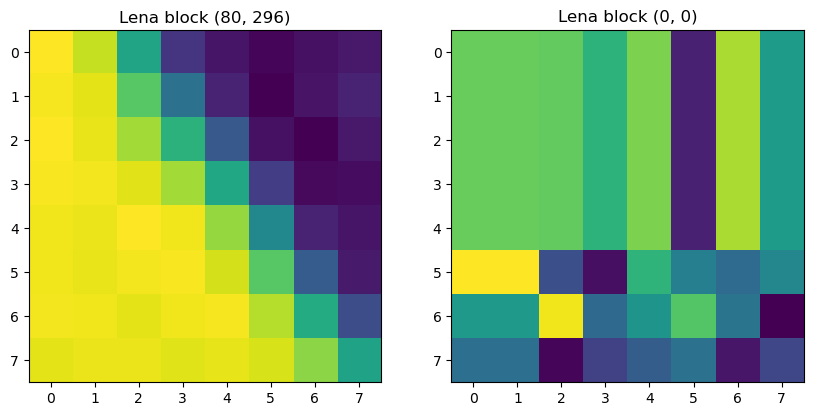

In [21]:
# 8x8 blocks
block1 = lena[80:80+8, 296:296+8] # Starts at (80,296)
block2 = lena[0:0+8, 0:0+8] # Starts at (0,0)

# Plot absolute value of the DCT
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(block1))
plt.title("Lena block (80, 296)")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(block2))
plt.title("Lena block (0, 0)")

12. Describe the energy distribution of the DCT of the sub-images. What does each pixel represent? Explain why DCT would be useful for image compression in the context of the DCT energy distribution.

In the DCT of block (80, 296), the energy is spread across multiple frequency components, particularly in the low- to mid-frequency range. The DCT of block (0, 0) shows most of its energy concentrated in the DC component, so this block is uniform with not much variation. 
Each pixel in the DCT plot represents the magnitude of a specific frequency component within the 8x8 sub-image. The top-left pixel is the DC component, while the other pixels are increasing frequency components in both horizontal and vertical directions as you move further from the top-left corner. 
The DCT is very useful for image compression because it compacts most of the image's energy into a few low-frequency components.

13. Compare the DCT of the two sub-images. How are they different? Why? Explain in the context of the image characteristics at those locations and the DCT energy distribution.

The DCT of the two sub-images are pretty different. As mentioned before, for block (80, 296), the energy is distributed across low- to mid-frequency components, which is a region of the image with more complexity, such as textures or edges. Looking as the block of Lena image that is represents, we can see there's an edge of sort. In contrast, block (0, 0) has nearly all its energy concentrated in the DC component, indicating a uniform region with little to no variation. This can also be seen in the Lena sub-image represented by the block. These differences occur because regions with high detail require a wider range of frequency components to represent their content, whereas uniform areas can be described using only the DC component.

In [22]:
mask = np.zeros((8,8))
mask[0,0] = 1
mask[0,1] = 1
mask[0,2] = 1
mask[1,0] = 1
mask[1,1] = 1
mask[2,0] = 1

In [23]:
F_thresh = blockproc(F_trans, mask, [8,8], func1)

In [24]:
f_thresh = np.floor(blockproc(F_thresh, T.T, [8,8], func)) + 128

In [25]:
f_thresh.min(), f_thresh.max()

(-27.0, 277.0)

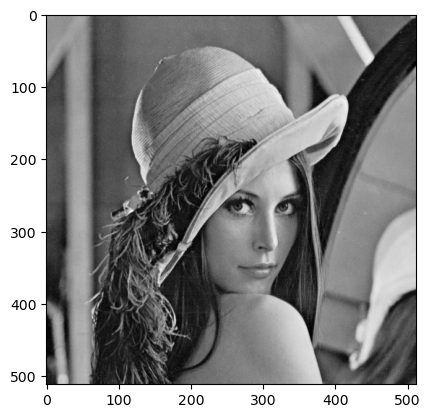

Text(0.5, 1.0, 'Reconstructed Lena Image (PSNR = 29.47)')

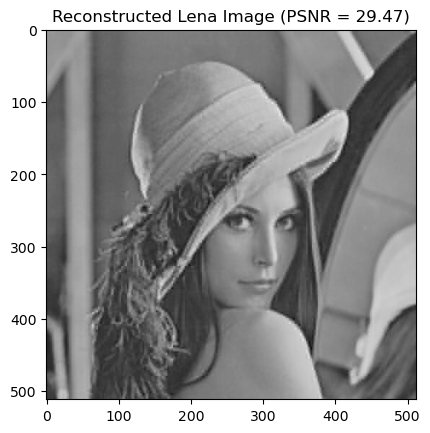

In [26]:
plt.imshow(lena, cmap = 'gray')
plt.show()

plt.imshow(f_thresh, cmap = 'gray')
plt.title(f'Reconstructed Lena Image (PSNR = {round(PSNR(lena, f_thresh / 255),2)})')

In [27]:
PSNR(lena, f_thresh / 255)

29.47022485312642

14. Describe how the reconstructed image looks compared to the original image. Why does it look this way?

The reconstructed image looks similar to the original image but looks slightly blurred and lighter. The blurring happens as the high-freuency components are discarded, leaving only the low-frequency components that don't represent the details. The image is lighter as the range is [-27,277] rather than [0,255].

15. What artifact is most prominent in the image? Why does this artifact appear?

The most prominent artifact in the reconstructed image is blocking artifacts, which are discontinuities between adjacent 8x8 blocks. This is visible near the edges of Lena's hat. These appear because the DCT is applied independently to each block, and discarding high-frequency components makes the pixel values discontinuous at the boundaries between blocks.

16. What conclusions can you draw about the DCT in terms of image compression? Does it work well? If yes, why does it work well?

The DCT works well for image compression because it concentrates most of the image's energy into a few low-frequency components, allowing significant data reduction without majorly affecting the perceived image quality. However, the effectiveness depends on the image content as smooth regions compress better than regions with high detail. So if the image has a lot of high details and sharp edges, the DCT would perform poorly. With that, we can see that its limitations are artifacts like blocking and loss of detail, especially at high compression levels.

Part 5 Quantization

In [28]:
Z = np.array([
[16, 11, 10, 16, 24, 40, 51, 61],
[12, 12, 14, 19, 26, 58, 60, 55],
[14, 13, 16, 24, 40, 57, 69, 56],
[14, 17, 22, 29, 51, 87, 80, 62],
[18, 22, 37, 56, 68, 109, 103, 77],
[24, 35, 55, 64, 81, 104, 113, 92],
[49, 64, 78, 87, 103, 121, 120, 101],
[72, 92, 95, 98, 112, 100, 103, 99]
])

In [29]:
(lena*255).min(), (lena*255).max()

(18.4994, 246.18609999999998)

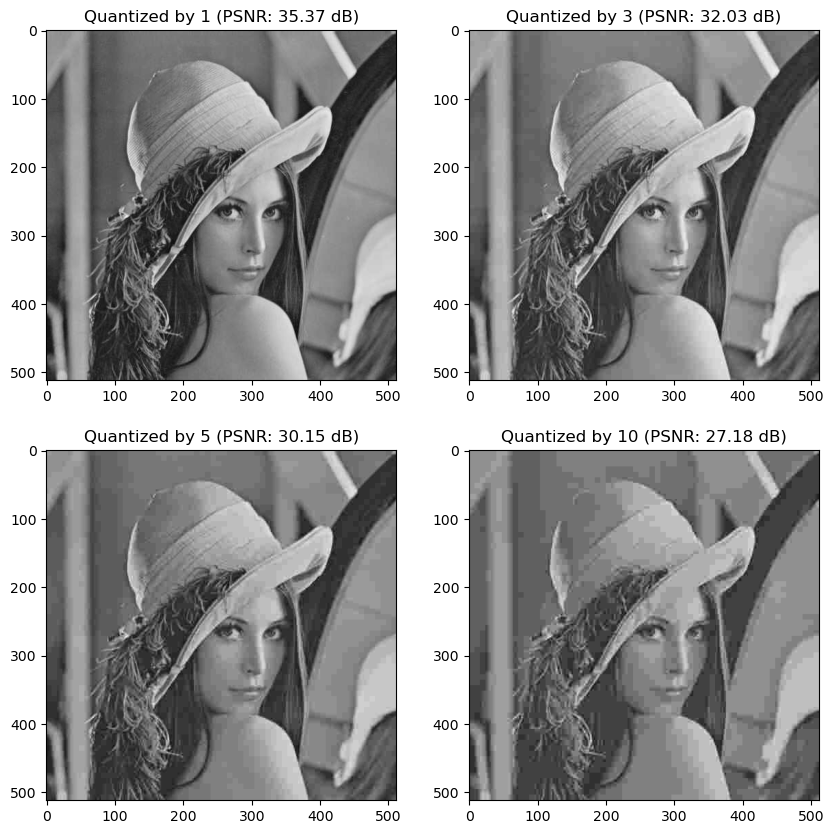

In [37]:
# Perform DCT on the image and quantization
def quantize_dct(im, compression_coeff, quantization_matrix=Z, subimg_dim=8):
    reconstructed_images = []  # List to store reconstructed images
    psnrs = []  # List to store PSNR values

    dct_matrix = dctmtx(subimg_dim)
    # Perform DCT and subtract 128
    img_dct = np.floor(blockproc((im * 255) - 128, dct_matrix, [subimg_dim, subimg_dim], func))
    
    for coeff in compression_coeff:  # Iterate over different compression coefficients
        Z_scaled = coeff * quantization_matrix  # Scale the quantization matrix
        
        tile_amount = int(im.shape[0] / subimg_dim)
        Z_scaled_tiled = np.tile(Z_scaled, (tile_amount, tile_amount))
        
        # Apply quantization
        img_dct_quantized = np.round(img_dct / Z_scaled_tiled).astype(int)
        
        # Reconstruct the image
        img_dct_recovered = img_dct_quantized * Z_scaled_tiled
        img_recovered = blockproc(img_dct_recovered, T.T, [subimg_dim, subimg_dim], func) + 128
        
        # Calculate PSNR
        psnrs.append(PSNR(im * 255, img_recovered, data_range=255))
        reconstructed_images.append(img_recovered)


    # Plot the reconstructed images and their corresponding PSNR
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
    for i, ax in enumerate(axes.flat):  # Flatten the axes array to iterate over it
        ax.imshow(reconstructed_images[i], cmap='gray')
        ax.set_title(f'Quantized by {compression_coeff[i]} (PSNR: {psnrs[i]:.2f} dB)')

    plt.show()

compression_coeff = [1, 3, 5, 10]  # Compression coefficients
quantize_dct(lena, compression_coeff)


17. What happens to the DCT coefficients when quantization is performed? What effect does it have on image quality?

Quantization reduces the precision of the DCT coefficients by dividing them by a quantization matrix and rounding them to integers. By doing this, it discards high-frequency components. The result is that the lower-frequency components are preserved while finer details are lost. Hence, the image quality decreases as the quantization coefficient increases.

18. Compare the reconstructed image produced using 3Z with the original image. Why does the reconstructed image look this way?

The reconstructed image produced using 3Z looks similar to the original image. Although, it's lighter (noticeable while looking at her hair) and slightly distorted. This is because the larger values in the quantization matrix cause a bigger reduction in the precision of the DCT coefficients, which leads to more loss of high-frequency components.

19. Compare the reconstructed images produced by the different levels of quantization, as well as the PSNR for each reconstructed image. What happens as the level of quantization increases?

As the level of quantization increases (from Z to 3Z, 5Z, and 10Z), the reconstructed images become more degraded. The PSNR values also decrease (from 35.37 to 27.18 dB), reflecting the higher distortion caused by more aggressive quantization. Higher quantization levels cause more significant loss of information as fine details are discarded, leading to blocking artifacts and less detail in the reconstructed images.

20. Which artifact becomes more prominent as the level of quantization increases? Why?

The artifact that becomes more prominent as the level of quantization increases is blocking artifacts. These occur because the image is divided into 8x8 blocks, and each block is quantized individually. As the quantization increases, the differences between adjacent blocks become more pronounced, leading to visible blocks within the image.

21. What conclusions can you draw about the quantization process? Explain in the context of the trade-off between compression performance and image quality.

The quantization process helps reduce the amount of data required to represent an image. However, it comes with a trade-off, as while quantization can significantly reduce file size (increasing compression performance), it also leads to a degradation in image quality. As the quantization level increases, more details are discarded, leading to more visible artifacts and a decrease in the PSNR. Hence, a balance is needed to get a good compression performance while maintaining image quality.